<a href="https://colab.research.google.com/github/pietromarini00/30412-Classification-with-LogisticRegression/blob/main/Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESCRIPTON


----------

This dataset is composed of 1200 samples with 35 features each. The first column
is the sample id. The second column in the dataset represents the label. There
are 5 possible values for the labels. The remaining columns are numeric
features.

Your task is the following: assuming that you want to classify this data with
Logistic Regression (implemented by sklearn.linear_model.LogisticRegression),
you should determine whether applying PCA to this dataset is useful, and if so
what number of components you would choose to use. At the end of the analysis,
you should have chosen an optimal strategy, including the optimal set of
parameters for the classifier: write this choice explicitly in the conclusions
of your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).

# Import Packages and Data

In [283]:
import pandas as pd
import numpy as np

from scipy.stats import loguniform

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import LSTM


Data = pd.read_csv('mldata_0003094072.csv')

# Data Preparation and Visualization

In [244]:
labels = Data['label']
features = Data.drop(columns=['Unnamed: 0','label'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb9ecc2750>,
      dtype=object)

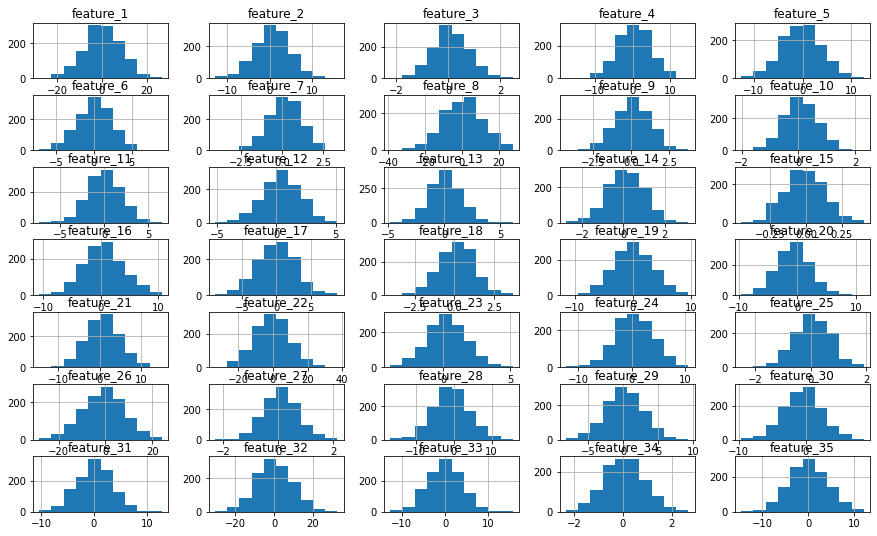

In [245]:
features.hist(figsize=(15,9), layout=(7,5))

Data Already looks Normally distributed, should we still go for a rescaling?

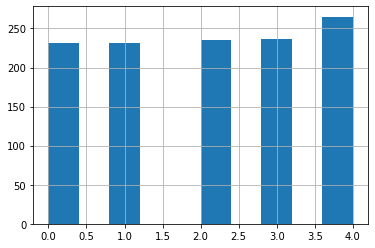

In [246]:
labels.hist()

Classes are almost perfectly balanced, it is not really necessary to use stratified sampling, but we never know, so I tried it too, and found out it delivers very similar (but slightly worse) results

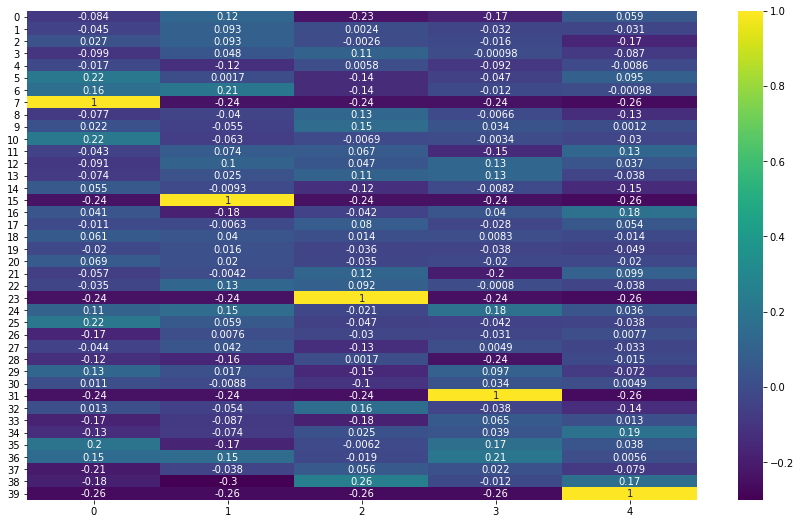

In [247]:
def correlation(features,df):
  y = pd.get_dummies(df.label, prefix='label')
  target_cols= np.arange(features.shape[1],features.shape[1]+y.shape[1])
  np_features = features.to_numpy()
  matrix = np.append(np_features,y, axis=1) 
  df = pd.DataFrame(matrix)
  corr_matrix = df.corr()
  map=[]
  for i in target_cols:
    most_correlated_features = corr_matrix[i].values.reshape(features.shape[1]+y.shape[1],1)
    map.append(most_correlated_features)
    #print(corr_matrix[i].sort_values(ascending=False))
  map = np.array(map).reshape(40,5)
  fig, ax = plt.subplots(figsize=(15,9))
  sns.heatmap(map, annot=True,ax=ax,cmap='viridis')
correlation(features,Data)

In [248]:
features.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.537747,0.599903,0.094714,0.437445,-0.287543,0.100894,0.157844,0.343041,0.083273,0.089775,-0.013457,0.407371,0.077296,0.110119,-0.009338,0.536562,-0.077199,0.155439,-0.008091,-0.714729,0.848633,-0.286941,0.249582,0.452351,0.067481,-0.831427,0.071756,-0.672589,0.124797,-0.452592,0.113184,0.045397,-0.119103,0.071709,-0.010214
std,8.280886,4.158050,0.694315,4.373206,4.068543,2.323017,1.008751,10.749965,1.160246,0.601856,1.917890,1.599477,1.397480,0.905573,0.138374,3.535027,2.755736,1.115841,3.352445,2.870847,4.090681,10.346132,1.500818,3.628688,0.657344,8.941232,0.623488,4.794596,2.670211,2.785172,3.394775,9.186563,3.940853,0.827774,4.232406
min,-27.927444,-12.994024,-2.235127,-17.719503,-12.543721,-7.197453,-4.146284,-38.740429,-4.272391,-2.014612,-7.379815,-5.174015,-4.817577,-2.806012,-0.450353,-10.732117,-9.000173,-4.038802,-11.559353,-9.549318,-14.475878,-33.538971,-3.989719,-12.359812,-2.494318,-28.280245,-2.309615,-16.699334,-8.255329,-9.632036,-10.322071,-30.754219,-12.693954,-2.348815,-14.593491
25%,-4.814249,-2.000171,-0.353134,-2.617755,-2.979183,-1.427281,-0.522847,-6.862036,-0.683507,-0.319334,-1.295812,-0.642718,-0.850135,-0.524722,-0.103660,-1.915450,-1.972813,-0.608140,-2.286750,-2.640615,-1.988146,-7.240400,-0.732849,-1.887101,-0.367372,-6.916969,-0.349212,-3.885086,-1.649932,-2.341065,-2.050383,-6.264539,-2.924524,-0.507311,-2.886984
50%,0.467960,0.838226,0.067960,0.578034,-0.320604,0.145843,0.189564,0.481231,0.062131,0.067138,-0.000821,0.411820,0.060772,0.116987,-0.013843,0.422070,-0.021565,0.180173,-0.021096,-0.749884,0.783918,-0.181956,0.210384,0.391307,0.071825,-0.639388,0.059726,-0.792753,0.157200,-0.432930,0.021544,-0.058583,-0.091578,0.063345,-0.026633
75%,6.106173,3.336066,0.565964,3.419695,2.462689,1.655129,0.805694,7.615251,0.871378,0.503978,1.251955,1.493330,0.975052,0.752544,0.087456,2.788507,1.815663,0.893509,2.340174,1.102171,3.549060,6.695453,1.301859,2.937969,0.544379,5.278754,0.463303,2.462328,1.888801,1.344736,2.434800,6.378856,2.525585,0.621703,2.954431
max,26.883436,15.971686,2.491952,14.810534,12.561359,9.019687,3.397375,27.545013,3.771634,2.302004,6.523992,5.160566,6.112456,3.159713,0.403436,10.723347,8.888041,3.690058,9.606745,11.275957,14.917117,37.235678,5.217805,10.610519,1.920238,24.104058,2.144743,15.611492,9.313357,8.662238,12.857374,32.736197,15.655862,2.689480,12.128355


# Preprocessing: Scaling 

Since the data is not standardized, maybe a scaling could improve the performance, we will try with and without

In [250]:
scaler = MaxAbsScaler()
# transform data
features = scaler.fit_transform(features)

# Evaluate

In [251]:
X, y = features, labels

we first run the model with default parameters to have a baseline for its performance

In [252]:
cv = KFold(n_splits=20, random_state=1, shuffle=True)
model = LogisticRegression()
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.538 (0.041)


The multinomial logistic regression model will be fit using cross-entropy loss and will predict the integer value for each integer encoded class label.
It sucks tho
Let's try with PCA

# Principal Component Analysis

Principal Component Analysis (PCA) is one of the most popular machine learning technique. It reduces the dimension of a given data set, making the data set more approachable and computationally cheaper to handle, while preserving most patterns and trends. This makes PCA an excellent tool for exploratory data analysis.

However, we claim that using PCA in supervised learning tasks, in particular in a pipeline such as:
 data → PCA → supervised learning algorithm
usually does more harm than good

PCA is still quite susceptible to throwing strong classification signals away.

from https://towardsdatascience.com/think-twice-before-you-use-principal-component-analysis-in-supervised-learning-tasks-70fbb68ebd0c

In [253]:
X = features
svd = np.linalg.svd
def get_optimal_number_of_components():
    cov = np.dot(X,X.transpose())/float(X.shape[0])
    U,s,v = svd(cov)

    S_nn = sum(s)

    for num_components in range(0,s.shape[0]):
        temp_s = s[0:num_components]
        S_ii = sum(temp_s)
        if (1 - S_ii/float(S_nn)) <= 0.01:
            return num_components

    return s.shape[0]

In [254]:
n_comp = get_optimal_number_of_components()
print ('optimal number of components = ', n_comp)

pca = PCA(n_components = n_comp)
X_new = pca.fit_transform(features)

optimal number of components =  29


In [217]:
X_new.shape

(1200, 29)

PCA does not have negative effect on predictions, the Accuracy is exactly the same, but since the size of the dataset is reduced, the training and the optimization time is cut by a significant amount, even though the reduction only compresses 35 dimensions into 29 not to lose classification signal.

# Hyperparameter Tuning

In [255]:
# define model
model = LogisticRegression()
# define evaluation
cv = KFold(n_splits=20, random_state=1, shuffle=True)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 100)
space['multi_class'] = ['ovr','multinomial']
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_new, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# print out the results of the randomized search

Best Score: 0.5441666666666667
Best Hyperparameters: {'C': 1.2586407337959669, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}


Best Score: 0.5441666666666667
Best Hyperparameters: {'C': 0.4152561875287414, 'penalty': 'l2', 'solver': 'liblinear'}

In [257]:
def print_10_best(result):
  best_10 = np.array(result.cv_results_['rank_test_score'][:10], dtype=int)
  for i in range(10):
    print(result.cv_results_['mean_test_score'][best_10[i]])
    print(result.cv_results_['params'][best_10[i]], '\n')

print_10_best(result)

nan
{'C': 0.47774172475935767, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'lbfgs'} 

nan
{'C': 65.22465359726905, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'newton-cg'} 

nan
{'C': 0.7544031147678008, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'newton-cg'} 

nan
{'C': 0.014740433620784678, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'lbfgs'} 

nan
{'C': 0.007854253333141461, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'liblinear'} 

0.54
{'C': 51.17535273948627, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'} 

nan
{'C': 0.003127848869971917, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'lbfgs'} 

0.5191666666666667
{'C': 0.0254147125594169, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'} 

nan
{'C': 0.003127848869971917, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'lbfgs'} 

nan
{'C': 0.04869417438121507, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'lbfgs'} 



In [262]:
X_tr, X_te, y_tr, y_te = train_test_split(X_new, labels, test_size=0.2,train_size=0.8)
model = LogisticRegression(multi_class='ovr', solver = 'liblinear', C=0.36000136157,penalty='l2')
model.fit(X_tr, y_tr)

LogisticRegression(C=0.36000136157, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Test:  0.55 

[[21  7  3  7  7]
 [ 4 25  5  2  6]
 [12  9 17  4 11]
 [ 8  2  3 28  5]
 [ 2  7  3  1 41]] 

              precision    recall  f1-score   support

           0       0.45      0.47      0.46        45
           1       0.50      0.60      0.54        42
           2       0.55      0.32      0.40        53
           3       0.67      0.61      0.64        46
           4       0.59      0.76      0.66        54

    accuracy                           0.55       240
   macro avg       0.55      0.55      0.54       240
weighted avg       0.55      0.55      0.54       240



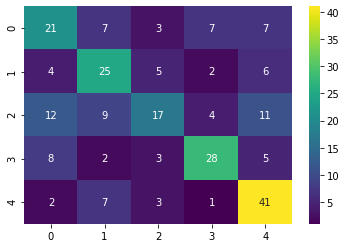

In [263]:
pred = model.predict(X_te)
print("Test: ", (accuracy_score(y_te,pred)),'\n')
print(confusion_matrix(y_te,pred),'\n')
sns.heatmap(confusion_matrix(y_te,pred), annot=True,cmap='viridis')
print(classification_report(y_te,pred))

# Other models:
- Support Vector Machine
- Extreme Gradient Boost
- Random Forest


In [233]:
# define model
model = SVC()
# define evaluation
cv = KFold(n_splits=20, random_state=1, shuffle=True)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = loguniform(1e-5, 100)
space['gamma'] = [1,0.1,0.01,0.001]
# define search
search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_new, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# print out the results of the randomized search

X_tr, X_te, y_tr, y_te = train_test_split(X_new, labels, test_size=0.2,train_size=0.8)
model = SVC()
model.fit(X_tr, y_tr)
pred = model.predict(X_te)
print("Test: ", (accuracy_score(y_te,pred)))
print(confusion_matrix(y_te,pred))
print(classification_report(y_te,pred))

Best Score: 0.7683333333333334
Best Hyperparameters: {'C': 1.8017093069504055, 'gamma': 0.1, 'kernel': 'rbf'}
Test:  0.7458333333333333
[[31  3  1  5  1]
 [ 1 37  4  1  6]
 [ 3  3 25  2  8]
 [ 4  5  5 37  2]
 [ 2  2  0  3 49]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        41
           1       0.74      0.76      0.75        49
           2       0.71      0.61      0.66        41
           3       0.77      0.70      0.73        53
           4       0.74      0.88      0.80        56

    accuracy                           0.75       240
   macro avg       0.74      0.74      0.74       240
weighted avg       0.75      0.75      0.74       240



In [234]:
X_tr, X_te, y_tr, y_te = train_test_split(features, labels, test_size=0.2,train_size=0.8)
model = XGBClassifier()
model.fit(X_tr, y_tr)
pred = model.predict(X_te)
print("Test: ", (accuracy_score(y_te,pred)))
print(confusion_matrix(y_te,pred))
print(classification_report(y_te,pred))

Test:  0.6125
[[29  7  6  2  1]
 [ 3 28  5  7  5]
 [10  3 23  6 13]
 [ 4  0  7 26  4]
 [ 2  4  3  1 41]]
              precision    recall  f1-score   support

           0       0.60      0.64      0.62        45
           1       0.67      0.58      0.62        48
           2       0.52      0.42      0.46        55
           3       0.62      0.63      0.63        41
           4       0.64      0.80      0.71        51

    accuracy                           0.61       240
   macro avg       0.61      0.62      0.61       240
weighted avg       0.61      0.61      0.61       240



In [235]:
X_tr, X_te, y_tr, y_te = train_test_split(X_new, labels, test_size=0.2,train_size=0.8)
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
pred = model.predict(X_te)
print("Test: ", (accuracy_score(y_te,pred)))
print(confusion_matrix(y_te,pred))
print(classification_report(y_te,pred))

Test:  0.6541666666666667
[[37  3  4  4  8]
 [ 1 31  6  7  2]
 [ 4  0 27  2  7]
 [ 5  1 12 29  6]
 [ 1  4  3  3 33]]
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        56
           1       0.79      0.66      0.72        47
           2       0.52      0.68      0.59        40
           3       0.64      0.55      0.59        53
           4       0.59      0.75      0.66        44

    accuracy                           0.65       240
   macro avg       0.66      0.66      0.65       240
weighted avg       0.67      0.65      0.66       240



In [289]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=29, activation='relu'))
	model.add(Dense(5, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [290]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_new, y, cv=kfold)


In [291]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 59.08% (3.42%)
